In [21]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv("hour.csv")

dataset['dteday'] = pd.to_datetime(dataset['dteday'])

dataset['dteday'] = dataset['dteday'].dt.day

dataset = dataset.drop(['instant'], axis=1)


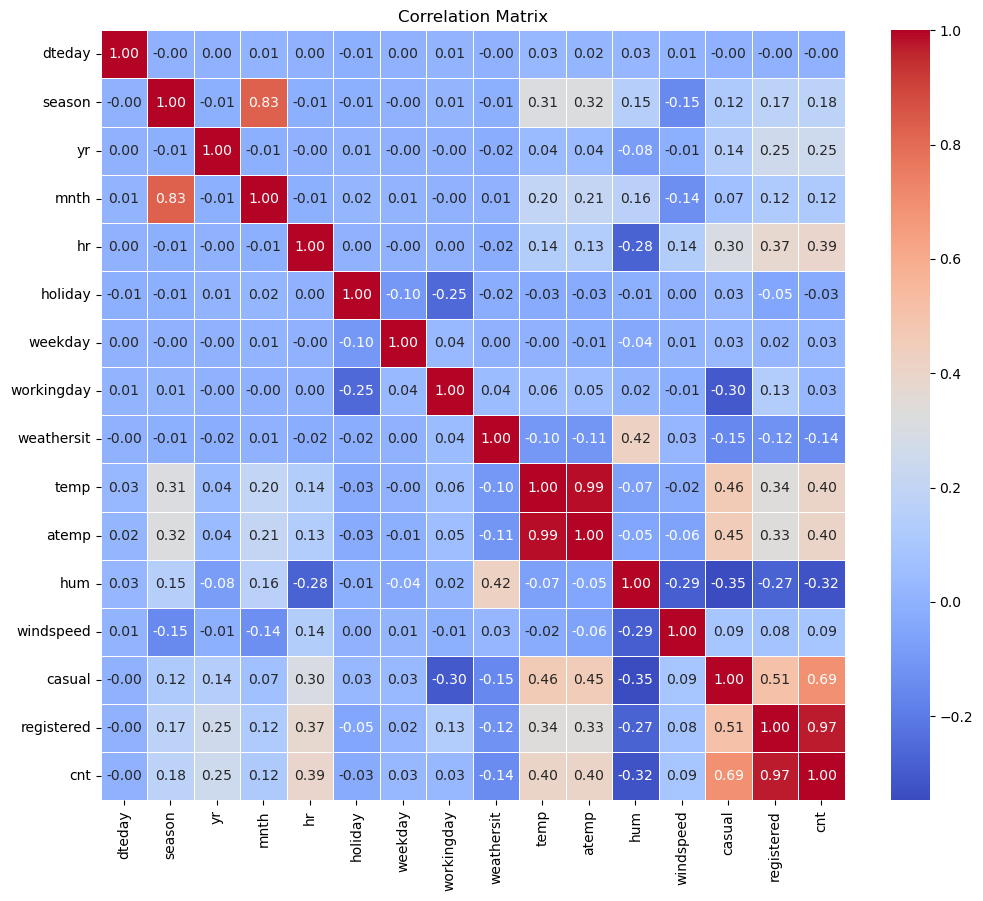

In [22]:
import seaborn as sns
corr_matrix = dataset.corr()

# Plot the Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [23]:
dataset = dataset.drop(['dteday', 'mnth', 'yr', 'holiday', 'weathersit', 'hum', 'windspeed', 'casual', 'registered'], axis=1)

print(dataset.head())

   season  hr  weekday  workingday  temp   atemp  cnt
0       1   0        6           0  0.24  0.2879   16
1       1   1        6           0  0.22  0.2727   40
2       1   2        6           0  0.22  0.2727   32
3       1   3        6           0  0.24  0.2879   13
4       1   4        6           0  0.24  0.2879    1


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
dataset_np = dataset.to_numpy()

X = dataset_np[:, :6]
Y = dataset_np[:,6]



XTrain, XTest, YTrain, YTest = train_test_split(X,Y, test_size=0.2, random_state=22)

rgr = RandomForestRegressor(max_depth=10, random_state=3)
rgr.fit(XTrain, YTrain)

print(rgr.score(XTrain, YTrain))
print(rgr.score(XTest, YTest))

random = np.random.randint(0, len(XTest))
sample = XTest[random]
sample = sample[np.newaxis, :]


print(f"Vorhersage: {rgr.predict(sample)}, Eigentliches Ergebniss: {YTest[random]}")




0.8448494931268967
0.8117109644217536
Vorhersage: [177.27677018], Eigentliches Ergebniss: 167.0


Degree: 1, Test MSE: 23970.9784, Test R²: 0.2743
Degree: 2, Test MSE: 18851.8535, Test R²: 0.4293
Degree: 3, Test MSE: 16369.5766, Test R²: 0.5044
Degree: 4, Test MSE: 15347.5632, Test R²: 0.5353
Degree: 5, Test MSE: 13842.9192, Test R²: 0.5809
Degree: 6, Test MSE: 12378.4820, Test R²: 0.6252
Degree: 7, Test MSE: 22763.5926, Test R²: 0.3108
Degree: 8, Test MSE: 40769.5247, Test R²: -0.2343

Best Degree: 6, Best Test MSE: 12378.4820


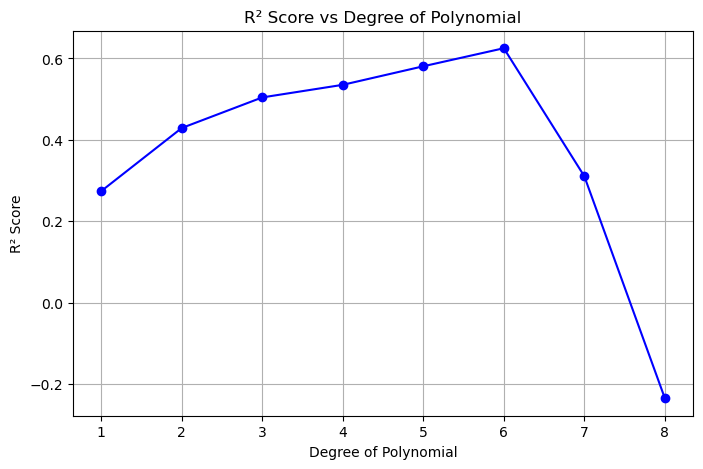

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Convert dataset to NumPy array
dataset_np = dataset.to_numpy()

# Split features and target
X = dataset_np[:, :6]  # Features
Y = dataset_np[:, 6]   # Target

# Train-Test Split
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.2, random_state=22)

best_degree = None
best_mse = float('inf')

# Store results for plotting
degrees = []
r2_scores = []

# Test Polynomial Features from Degree 1 to 8
for degree in range(1, 9):  # Degrees from 1 to 8
    # Generate Polynomial Features
    poly = PolynomialFeatures(degree=degree)
    XTrain_poly = poly.fit_transform(XTrain)
    XTest_poly = poly.transform(XTest)
    
    # Train Polynomial Regression
    model = LinearRegression()
    model.fit(XTrain_poly, YTrain)
    
    # Evaluate on Test Data
    predictions = model.predict(XTest_poly)
    mse = mean_squared_error(YTest, predictions)
    r2 = model.score(XTest_poly, YTest)
    
    print(f"Degree: {degree}, Test MSE: {mse:.4f}, Test R²: {r2:.4f}")
    
    # Update Best Model
    if mse < best_mse:
        best_mse = mse
        best_degree = degree
    
    # Store results for plotting
    degrees.append(degree)
    r2_scores.append(r2)

print(f"\nBest Degree: {best_degree}, Best Test MSE: {best_mse:.4f}")

# Simple Plot of R² Scores
plt.figure(figsize=(8, 5))
plt.plot(degrees, r2_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Degree of Polynomial')
plt.ylabel('R² Score')
plt.title('R² Score vs Degree of Polynomial')
plt.grid()
plt.show()


In [44]:
# PolynomialFeatures for the best degree
best_poly = PolynomialFeatures(degree=best_degree)
XTrain_poly = best_poly.fit_transform(XTrain)  # Fit and transform on training data
XTest_poly = best_poly.transform(XTest)       # Transform test data for consistency

# Re-train the best model using the best polynomial degree
best_model = LinearRegression()
best_model.fit(XTrain_poly, YTrain)

# Predict a random sample
random = np.random.randint(0, len(XTest))
sample = XTest[random].reshape(1, -1)  # Reshape for compatibility
sample_poly = best_poly.transform(sample)  # Transform using the best polynomial transformation

# Make prediction
predicted = best_model.predict(sample_poly)
print(f"Prediction: {predicted[0]}, Actual: {YTest[random]}")

Prediction: 363.0729434708114, Actual: 192.0


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Split Features and Target
X = dataset.iloc[:, :-1]  # Features
y = dataset.iloc[:, -1]   # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Pipeline for Polynomial Regression with Standardization
pipeline = Pipeline([
    ('scaler', StandardScaler()),                 # Standardize data
    ('poly_features', PolynomialFeatures()),     # Add polynomial features
    ('regressor', LinearRegression())            # Linear Regression
])

# Grid Search for Best Degree of Polynomial
param_grid = {'poly_features__degree': [4, 5, 6, 7]}  # Test degrees from 4 to 7
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Model and Parameters
best_model = grid_search.best_estimator_
best_degree = grid_search.best_params_['poly_features__degree']

print(f"Best Degree: {best_degree}")
print(f"Best Cross-Validation R²: {grid_search.best_score_}")

# Evaluate on Test Data
y_pred = best_model.predict(X_test)
r2 = best_model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Test R²: {r2}")
print(f"Test MSE: {mse}")

# Random Prediction Example
random = np.random.randint(0, len(X_test))
sample = X_test.iloc[random, :].values.reshape(1, -1)
predicted = best_model.predict(sample)
print(f"Prediction: {predicted[0]}, Actual: {y_test.iloc[random]}")

Best Degree: 6
Best Cross-Validation R²: 0.5995046705306344
Test R²: 0.6249465700542266
Test MSE: 12388.060688947897
Prediction: 66.24321164190769, Actual: 10


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


--- Running Scenario: No Scaling ---
Scenario: No Scaling, Test R²: 0.6252, Test MSE: 12378.4820
--- Running Scenario: StandardScaler ---
Scenario: StandardScaler, Test R²: 0.6249, Test MSE: 12388.0590
--- Running Scenario: MinMaxScaler ---
Scenario: MinMaxScaler, Test R²: 0.6247, Test MSE: 12396.0234
--- Running Scenario: PCA + StandardScaler ---
Scenario: PCA + StandardScaler, Test R²: 0.6297, Test MSE: 12232.5959
--- Running Scenario: PCA + MinMaxScaler ---
Scenario: PCA + MinMaxScaler, Test R²: 0.6297, Test MSE: 12231.2920

Summary of Results:
               Scenario   Test R²      Test MSE
0            No Scaling  0.625237  12378.482021
1        StandardScaler  0.624947  12388.059046
2          MinMaxScaler  0.624705  12396.023443
3  PCA + StandardScaler  0.629653  12232.595876
4    PCA + MinMaxScaler  0.629693  12231.291995


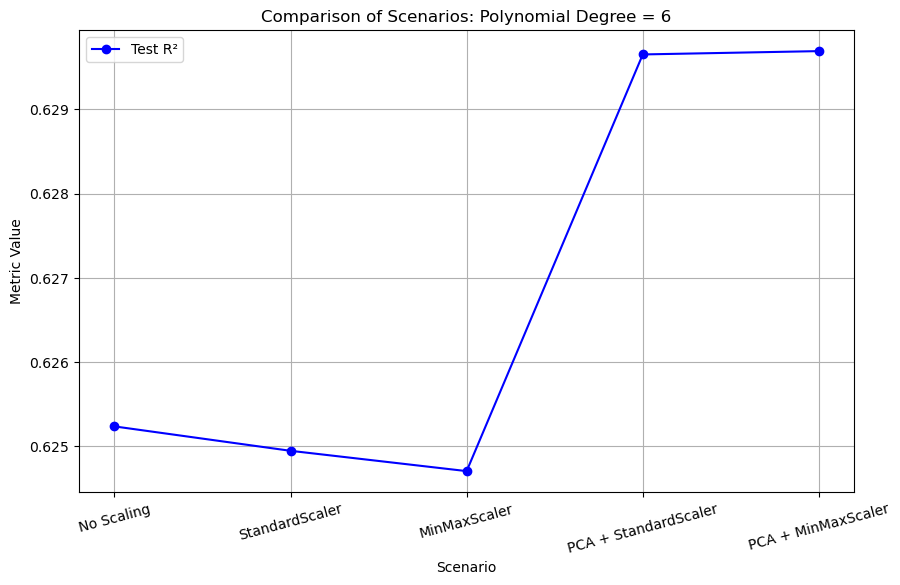

In [47]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Scenarios and Preprocessing
scenarios = {
    "No Scaling": None,
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "PCA + StandardScaler": ("pca", StandardScaler()),
    "PCA + MinMaxScaler": ("pca", MinMaxScaler())
}

# Store Results
scenario_results = []

# Iterate Over Scenarios
for name, preprocessing in scenarios.items():
    print(f"--- Running Scenario: {name} ---")
    
    # Define preprocessing steps
    XTrain_preprocessed, XTest_preprocessed = XTrain, XTest
    if preprocessing is not None:
        if name.startswith("PCA"):
            # Apply scaler
            scaler = preprocessing[1]
            XTrain_scaled = scaler.fit_transform(XTrain)
            XTest_scaled = scaler.transform(XTest)
            
            # Apply PCA
            pca = PCA(n_components=0.95)  # Retain 95% variance
            XTrain_preprocessed = pca.fit_transform(XTrain_scaled)
            XTest_preprocessed = pca.transform(XTest_scaled)
        else:
            # Apply only StandardScaler or MinMaxScaler
            scaler = preprocessing
            XTrain_preprocessed = scaler.fit_transform(XTrain)
            XTest_preprocessed = scaler.transform(XTest)

    # Polynomial Features
    poly = PolynomialFeatures(degree=6)
    XTrain_poly = poly.fit_transform(XTrain_preprocessed)
    XTest_poly = poly.transform(XTest_preprocessed)

    # Train Model
    model = LinearRegression()
    model.fit(XTrain_poly, YTrain)

    # Evaluate Model
    YPred = model.predict(XTest_poly)
    test_r2 = model.score(XTest_poly, YTest)
    test_mse = mean_squared_error(YTest, YPred)

    print(f"Scenario: {name}, Test R²: {test_r2:.4f}, Test MSE: {test_mse:.4f}")

    # Store Results
    scenario_results.append({"Scenario": name, "Test R²": test_r2, "Test MSE": test_mse})

# Convert Results to DataFrame
results_df = pd.DataFrame(scenario_results)
print("\nSummary of Results:")
print(results_df)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(results_df["Scenario"], results_df["Test R²"], marker='o', label='Test R²', color='b')
plt.title("Comparison of Scenarios: Polynomial Degree = 6")
plt.xlabel("Scenario")
plt.ylabel("Metric Value")
plt.legend()
plt.grid()
plt.xticks(rotation=15)  # Rotate x-axis labels for clarity
plt.show()
